In [2]:
import os
import torch.nn as nn
import torch.nn.functional as F

import torch
import torchio as tio
import glob
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import random
import math

# device = "cpu"
device = "cuda" if torch.cuda.is_available() else "cpu"

c:\Users\user\anaconda3\envs\Synthseg\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Original Labels

In [3]:
def show_slices(image, layer, cmap):
    plt.figure(figsize=(10, 10))
    plt.subplot(131)
    plt.imshow(image[layer[0], :, :], cmap=cmap)
    plt.subplot(132)
    plt.imshow(image[:, layer[1], :], cmap=cmap)
    plt.subplot(133)
    plt.imshow(image[:, :, layer[2]], cmap=cmap)
    plt.show()

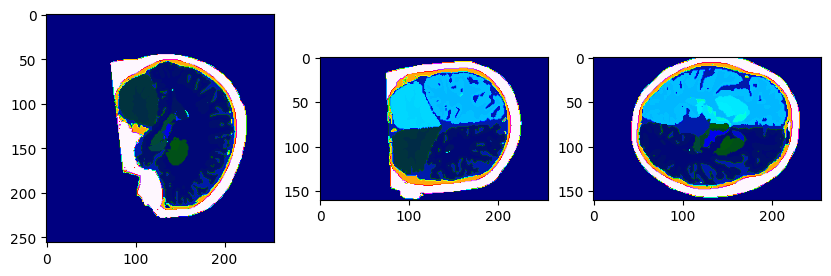

In [4]:
label = nib.load("samseg.nii.gz").get_fdata()
label = torch.from_numpy(label).float().to(device)
show_slices(label.cpu(), (100, 100, 140), "gist_ncar")

# Training Augmentations

**Random Skull Stripping**

In [5]:
def random_skull_strip(label, verbose=False):
    skull_indexs = [30, 62, 85, 165, 258, 259]
    
    output = torch.clone(label)
    if random.choice((0, 1)):
        if verbose: print("skull strip")
        for idx in skull_indexs:
            output[output == idx] = 0
            
        if random.choice((0, 1)):
            if verbose: print("remove CSF")
            output[output == 24] = 0
            
    return output

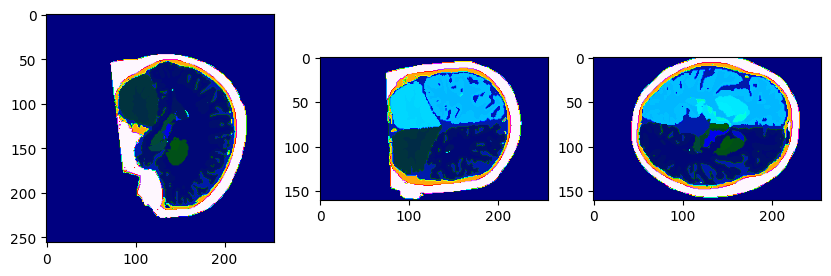

In [6]:
show_slices(random_skull_strip(label, True).cpu(), (100, 100, 140), "gist_ncar")

**Random Left/Right Flipping**

In [7]:
def random_lr_flip(image, p=0.5, verbose=False):
    """input/output 5D tensor (N, C, D, H, W)"""
    if random.random() > p:
        if verbose: print("flip image")
        return image.flip(dims=(2,))
    else:
        return image

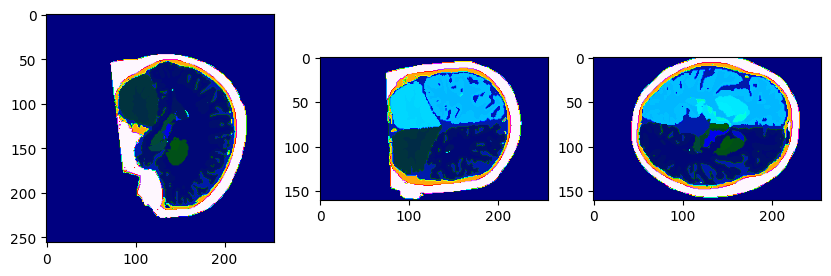

In [8]:
show_slices(random_lr_flip(label[None, None, ...], verbose=True)[0, 0, ...].cpu(), (100, 100, 140), "gist_ncar")

**Random 160^3 cropping**

In [21]:
def random_crop(image, size):
    """input/output tensor num_dims >= 3"""
    size = (size,) * 3 if type(size) == int else size

    i = random.randint(0, image.shape[-3] - size[0])
    j = random.randint(0, image.shape[-2] - size[1])
    k = random.randint(0, image.shape[-1] - size[2])
    
    return image[..., i:i+size[0], j:j+size[1], k:k+size[2]]

0 86 0


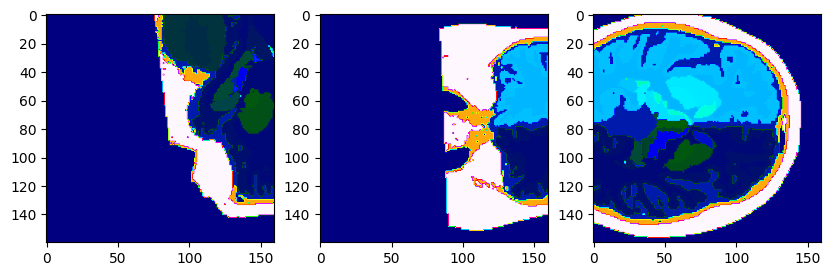

0 23 13
torch.Size([1, 1, 160, 160, 160])


In [25]:
show_slices(random_crop(label[None, None, ...], 160)[0, 0, ...].cpu(), (100, 100, 140), "gist_ncar")

skull strip


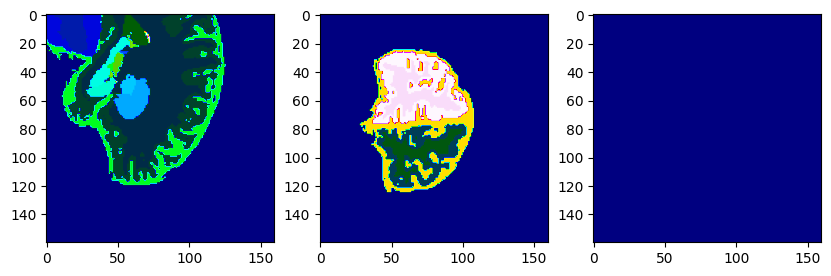

In [77]:
image = label[None, None, ...]
image = random_skull_strip(image, verbose=True)
image = random_lr_flip(image, verbose=True)
image = random_crop(image)

show_slices(image[0, 0, ...].cpu(), (100, 100, 140), "gist_ncar")

# Scale

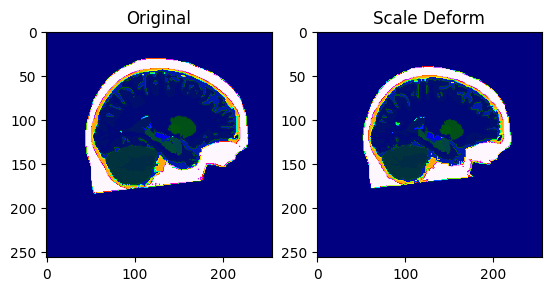

In [4]:
minSC, maxSC =  0.8, 1.2
scale = torch.diag( torch.FloatTensor(3).uniform_(minSC, maxSC) )
affine = torch.zeros((3, 4))
affine[:3, :3] = scale

grid = F.affine_grid(affine.unsqueeze(0), label[None, None, ...].size(), align_corners=False).to(device)
new_label = F.grid_sample(label.unsqueeze(0).unsqueeze(0), grid, 'nearest', align_corners=False)[0, 0, ...]

layer = 100
plt.figure()
plt.subplot(121)
plt.title("Original")
plt.imshow(np.rot90(label[layer, :, :].cpu()), cmap="gist_ncar")
plt.subplot(122)
plt.title("Scale Deform")
plt.imshow(np.rot90(new_label[layer, :, :].cpu()), cmap="gist_ncar")
plt.show()

# Rotation

In [5]:
# label = F.pad(label, pad=(0, 0, 0, 0, 48, 48))
label.shape

torch.Size([160, 256, 256])

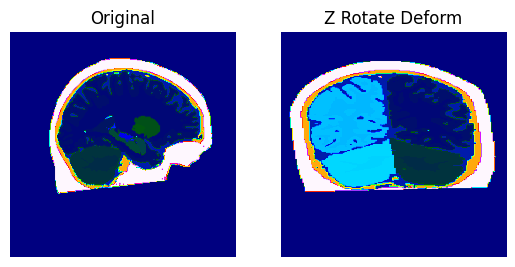

In [6]:
angle = (90, 90)
angleX = math.radians(random.uniform(angle[0], angle[1]))
angleY = math.radians(random.uniform(angle[0], angle[1]))
angleZ = math.radians(random.uniform(angle[0], angle[1]))

from math import sin, cos
rotX = torch.tensor([[1.,  cos(angleY),  sin(angleY)],
                     [0.,           1.,           0.],
                     [-sin(angleX), 0.,  cos(angleY)]])

rotY = torch.tensor([[cos(angleY), -sin(angleY), 1.],
                     [sin(angleX),  cos(angleY), 0.],
                     [0.,          0.,           1.],])

rotZ = torch.tensor([[1.,          0.,           0.],
                     [0., cos(angleX), -sin(angleX)],
                     [0., sin(angleX),  cos(angleX)]])

affine = torch.zeros((3, 4))
# affine[:3, :3] = torch.linalg.multi_dot((rotX, rotY, rotZ))
affine[:3, :3] = rotZ

grid = F.affine_grid(affine.unsqueeze(0), label[None, None, ...].size(), align_corners=False).to(device)
new_label = F.grid_sample(label.unsqueeze(0).unsqueeze(0), grid, 'nearest', align_corners=False)[0, 0, ...]

layer = 100
plt.figure()
plt.subplot(121)
plt.title("Original")
plt.imshow(np.rot90(label[layer, :, :].cpu()), cmap="gist_ncar")
plt.axis("off")
plt.subplot(122)
plt.title("Z Rotate Deform")
plt.imshow(np.rot90(new_label[layer, :, :].cpu()), cmap="gist_ncar")
plt.axis("off")
plt.show()

# Shear

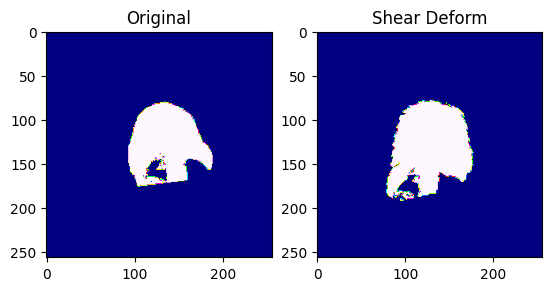

In [7]:
shear = (-0.15, 0.15)
shX = random.uniform(shear[0], shear[1])
shY = random.uniform(shear[0], shear[1])
shZ = random.uniform(shear[0], shear[1])

shearX = torch.tensor([[ 1.,  0.,   0.],
                       [shX,  1.,   0.],
                       [shX,  0.,   1.]])

shearY = torch.tensor([[1.,  shY,   0.],
                       [0.,   1.,   0.],
                       [0.,  shY,   1.]])

shearZ = torch.tensor([[1.,  0.,  shZ],
                       [0.,  1.,  shZ],
                       [0.,  0.,   1.]])
affine = torch.zeros((3, 4))
affine[:3, :3] = torch.linalg.multi_dot((shearX, shearY, shearZ))

grid = F.affine_grid(affine.unsqueeze(0), label[None, None, ...].size(), align_corners=False).to(device)
new_label = F.grid_sample(label.unsqueeze(0).unsqueeze(0), grid, 'nearest', align_corners=False)[0, 0, ...]

layer = 150
plt.figure()
plt.subplot(121)
plt.title("Original")
plt.imshow(np.rot90(label[layer, :, :].cpu()), cmap="gist_ncar")
plt.subplot(122)
plt.title("Shear Deform")
plt.imshow(np.rot90(new_label[layer, :, :].cpu()), cmap="gist_ncar")
plt.show()

# Translation

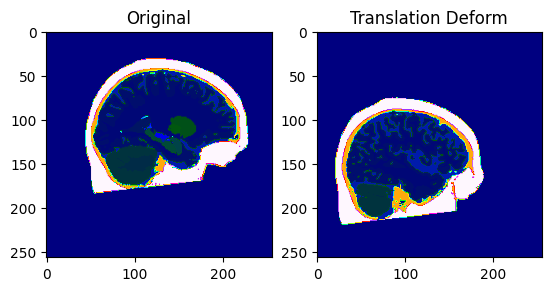

In [8]:
minTR, maxTR = -0.3, 0.3
trans = torch.FloatTensor(3).uniform_(minTR, maxTR)
affine = torch.zeros((3, 4))
affine[:3, :3] = torch.diag(torch.ones((3, )))
affine[:, -1] = trans

grid = F.affine_grid(affine.unsqueeze(0), label[None, None, ...].size(), align_corners=False).to(device)
new_label = F.grid_sample(label.unsqueeze(0).unsqueeze(0), grid, 'nearest', align_corners=False)[0, 0, ...]

layer = 100
plt.figure()
plt.subplot(121)
plt.title("Original")
plt.imshow(np.rot90(label[layer, :, :].cpu()), cmap="gist_ncar")
plt.subplot(122)
plt.title("Translation Deform")
plt.imshow(np.rot90(new_label[layer, :, :].cpu()), cmap="gist_ncar")
plt.show()

In [9]:
import math
from math import sin, cos

def linear_deform(label, verbose=False):
    label = F.pad(label, pad=(0, 0, 0, 0, 48, 48))
    minSC, maxSC =  0.8, 1.2 # scale
    scale = torch.diag( torch.FloatTensor(3).uniform_(minSC, maxSC) )

    minTR, maxTR = -0.3, 0.3
    trans = torch.FloatTensor(3).uniform_(minTR, maxTR)

    angle = (-20, 20)
    angleX = math.radians(random.uniform(angle[0], angle[1]))
    angleY = math.radians(random.uniform(angle[0], angle[1]))
    angleZ = math.radians(random.uniform(angle[0], angle[1]))
    
    from math import sin, cos
    rotX = torch.tensor([[1.,  cos(angleY),  sin(angleY)],
                         [0.,           1.,           0.],
                         [-sin(angleX), 0.,  cos(angleY)]])

    rotY = torch.tensor([[cos(angleY), -sin(angleY), 1.],
                         [sin(angleX),  cos(angleY), 0.],
                         [0.,          0.,           1.],])

    rotZ = torch.tensor([[1.,          0.,           0.],
                         [0., cos(angleX), -sin(angleX)],
                         [0., sin(angleX),  cos(angleX)]])

    shear = (-0.15, 0.15)
    shX = random.uniform(shear[0], shear[1])
    shY = random.uniform(shear[0], shear[1])
    shZ = random.uniform(shear[0], shear[1])

    shearX = torch.tensor([[ 1.,  0.,   0.],
                           [shX,  1.,   0.],
                           [shX,  0.,   1.]])

    shearY = torch.tensor([[1.,  shY,   0.],
                           [0.,   1.,   0.],
                           [0.,  shY,   1.]])

    shearZ = torch.tensor([[1.,  0.,  shZ],
                           [0.,  1.,  shZ],
                           [0.,  0.,   1.]])

    from torch.linalg import multi_dot
    affine = torch.zeros((3, 4))
    affine[:3, :3] = multi_dot((scale, rotX, rotY, rotZ, shearX, shearY, shearZ))
    affine[:, 3] = trans

    grid = F.affine_grid(affine[None, ...], label[None, None, ...].size()).to(device)
    new_label = F.grid_sample(label[None, None, ...], grid, 'nearest')
    
    if verbose:
        print(scale)
        print(trans)
        print(rotX)
        print(rotY)
        print(rotZ)
        print(shearX)
        print(shearY)
        print(shearZ)
        print(affine, affine.dtype)
    
    return new_label[0, 0, 48:-48, :, :]

# GMM Sampling

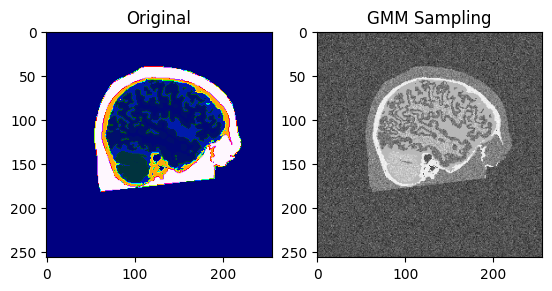

In [21]:
def get_image(label, mean=(0, 255), std=(0, 35)):
#     index_all = [0,  2,  3,   4,   5,   7,   8,   10,  11,  12,  13,  14,  15,  16,  17,
#                    18, 24,  26,  28,  30,  31,  41,  42,  43,  44,  46,  47,  49,  50,
#                    51, 52,  53,  54,  58,  60,  62,  63,  77,  85,  165, 258, 259]
    
    index_all = torch.unique(label)

    gen_ima = label * 0
    for ii in index_all:    
        mu = random.uniform(mean[0], mean[1])
        sigma = random.uniform(std[0], std[1]) # mean and standard deviation
        len1 = torch.sum(label==ii).item()
        gen_ima[label==ii] = torch.normal(mu , sigma, (len1,), device=label.device)
    
    return gen_ima

img = get_image(label)
layer = 120
plt.figure()
plt.subplot(121)
plt.title("Original")
plt.imshow(np.rot90(label[layer, :, :].cpu()), cmap="gist_ncar")
plt.subplot(122)
plt.title("GMM Sampling")
plt.imshow(np.rot90(img[layer, :, :].cpu()), cmap="gray")
plt.show()

# Bias Field

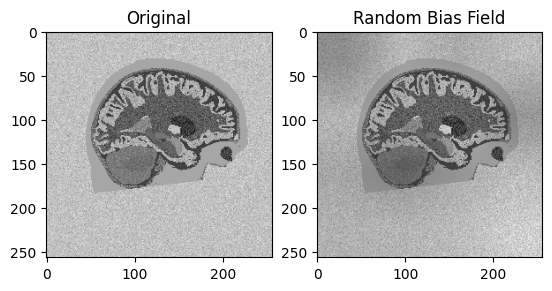

In [11]:
def bias_field(label, max_std=0.6, mode='trilinear'):
    std = random.uniform(0, max_std)
    B = torch.normal(0, std, (4, 4, 4), device=label.device)
    B = nn.functional.interpolate(input=B[None, None, ...], size=label.shape[-3:], mode=mode)
    B = B[0, 0, ...]
    B = torch.exp(B)
    
    return label * B

img = get_image(label)
new_img = bias_field(img)

layer = 100
plt.figure()
plt.subplot(121)
plt.title("Original")
plt.imshow(np.rot90(img[layer, :, :].cpu()), cmap="gray")
plt.subplot(122)
plt.title("Random Bias Field")
plt.imshow(np.rot90(new_img[layer, :, :].cpu()), cmap="gray")
plt.show()

# Intensity augmentation

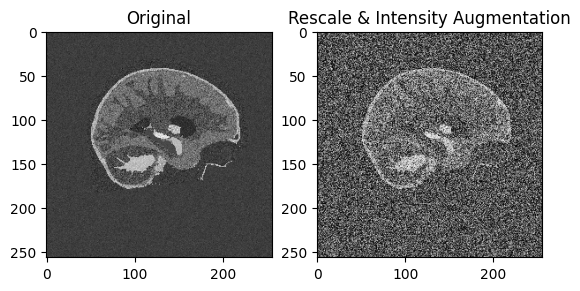

In [12]:
def rescale(img, noise_std=0.632 , out_min_max=(0, 1)):
    img = (img - img.min()) / (img.max() - img.min())
    img = torch.pow( img, torch.exp(torch.normal(0, noise_std, img.shape, device=img.device)) )
    
    return img

img = get_image(label)
new_img = rescale(img)

layer = 100
plt.figure()
plt.subplot(121)
plt.title("Original")
plt.imshow(np.rot90(img[layer, :, :].cpu()), cmap="gray")
plt.subplot(122)
plt.title("Rescale & Intensity Augmentation")
plt.imshow(np.rot90(new_img[layer, :, :].cpu()), cmap="gray")
plt.show()

# Resolution Variability

In [13]:
def get_gauss(sigma, kernel_size = 3):
    # Calculate the center of the kernel
    center = (kernel_size - 1) / 2

    # Create a 3D coordinate grid
    x = torch.linspace(-center, center, kernel_size)
    y = torch.linspace(-center, center, kernel_size)
    z = torch.linspace(-center, center, kernel_size)
    xx, yy, zz = torch.meshgrid(x, y, z)

    # Calculate the Gaussian function
    gaussian = torch.exp(-(xx**2 + yy**2 + zz**2) / (2 * sigma**2))

    # Normalize the kernel so that it sums to 1
    gaussian = gaussian / torch.sum(gaussian)
    
    return gaussian

C:\Users\user\anaconda3\envs\Synthseg\lib\site-packages\torch\functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:2895.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


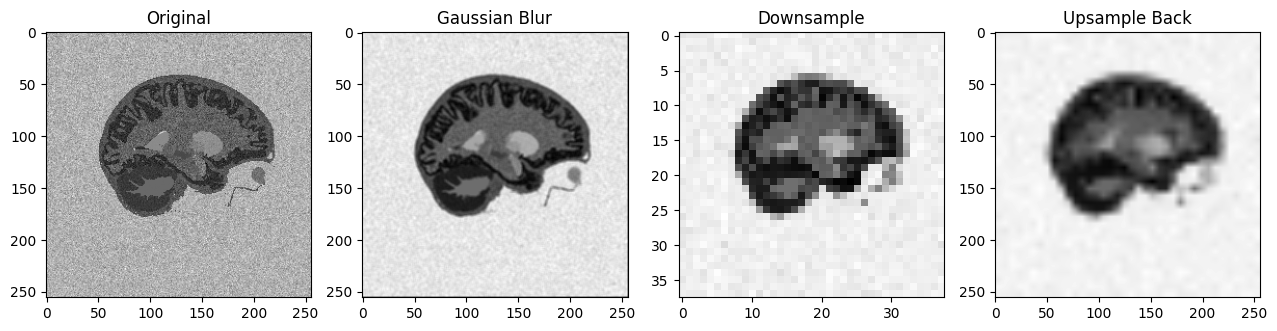

In [14]:



img = get_image(label)
r_spac = random.uniform(1, 9)
r_thick = random.uniform(1, r_spac)
a = random.uniform(0.95, 1.05)
std_thick = (2 * a * math.log(10) * r_thick) / (2 * math.pi * 1)

origin_shape = img.size()
sample_shape = (torch.tensor(img.size()) / r_spac).int()
sample_shape = torch.Size(sample_shape.tolist())

gauss_kernel = get_gauss(sigma=std_thick).to(img.device)
blur_img = F.conv3d(img[None, None, ...], weight=gauss_kernel[None, None, ...], padding=1)

# downsample to low resolution r_spac
down_img = F.interpolate(input=blur_img,  size=sample_shape, mode='trilinear')
# upsample back to r_hr
up_img = F.interpolate(input=down_img, size=origin_shape, mode='trilinear')

blur_img = blur_img[0, 0, ...]
down_img = down_img[0, 0, ...]
up_img = up_img[0, 0, ...]
layer = 100
plt.figure()
plt.subplot(141)
plt.title("Original")
plt.imshow(np.rot90(img[layer, :, :].cpu()), cmap="gray")
plt.subplot(142)
plt.title("Gaussian Blur")
plt.imshow(np.rot90(blur_img[layer, :, :].cpu()), cmap="gray")
plt.subplot(143)
plt.title("Downsample")
plt.imshow(np.rot90(down_img[int(layer/r_spac), :, :].cpu()), cmap="gray")
plt.subplot(144)
plt.title("Upsample Back")
plt.imshow(np.rot90(up_img[layer, :, :].cpu()), cmap="gray")
plt.tight_layout(rect=[0, 0.02, 2, 0.95])
plt.show()

In [15]:
def downsample(img):
    r_spac = random.uniform(1, 9)
    r_thick = random.uniform(1, r_spac)
    a = random.uniform(0.95, 1.05)
    std_thick = (2 * a * math.log(10) * r_thick) / (2 * math.pi * 1)
    
    origin_shape = img.size()
    sample_shape = (torch.tensor(img.size()) / r_spac).int()
    sample_shape = torch.Size(sample_shape.tolist())
    
    gauss_kernel = get_gauss(sigma=std_thick).to(img.device)
    img = F.conv3d(img[None, None, ...], weight=gauss_kernel[None, None, ...], padding=1)
    
    # downsample to low resolution r_spac
    img = F.interpolate(input=img,  size=sample_shape, mode='trilinear')
    # upsample back to r_hr
    img = F.interpolate(input=img, size=origin_shape, mode='trilinear')
    img = img[0, 0, ...]
    
    return img

C:\Users\user\anaconda3\envs\Synthseg\lib\site-packages\torch\nn\functional.py:4277: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
C:\Users\user\anaconda3\envs\Synthseg\lib\site-packages\torch\nn\functional.py:4215: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


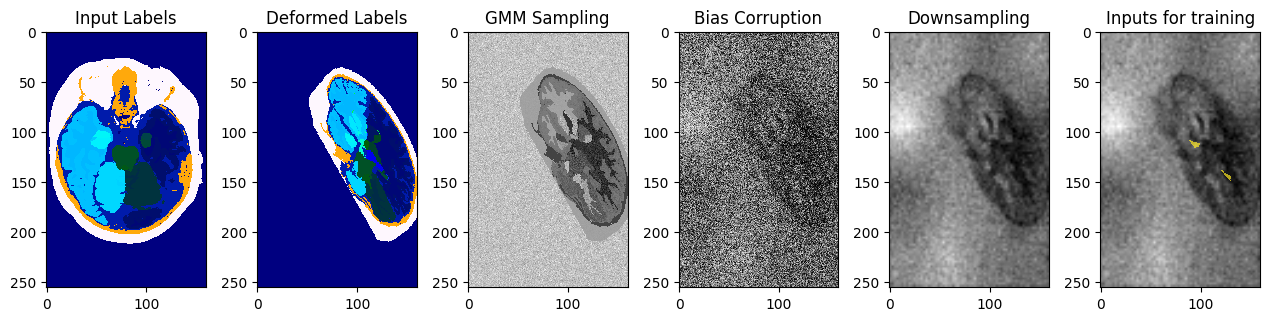

In [16]:
new_label = linear_deform(label)
new_img = get_image(new_label)
bias_img = bias_field(new_img)
bias_img = rescale(bias_img)
down_img = downsample(bias_img)
mask = (new_label != 17) & (new_label != 53)
input_label = new_label.cpu() * 0
input_label[mask] = 0.0
input_label[~mask] = 1.0

layer = 120
plt.figure()
plt.subplot(161)
plt.title("Input Labels")
plt.imshow(np.rot90(label[..., layer].cpu()), cmap="gist_ncar")

plt.subplot(162)
plt.title("Deformed Labels")
plt.imshow(np.rot90(new_label[..., layer].cpu()), cmap="gist_ncar")

plt.subplot(163)
plt.title("GMM Sampling")
plt.imshow(np.rot90(new_img[..., layer].cpu()), cmap="gray")

plt.subplot(164)
plt.title("Bias Corruption")
plt.imshow(np.rot90(bias_img[..., layer].cpu()), cmap="gray")

plt.subplot(165)
plt.title("Downsampling")
plt.imshow(np.rot90(down_img[..., layer].cpu()), cmap="gray")

plt.subplot(166)
plt.title("Inputs for training")
plt.imshow(np.rot90(down_img[..., layer].cpu()), cmap="gray")
plt.imshow(np.rot90(input_label[..., layer]), alpha = 0.7 * np.rot90(input_label[..., layer]))

plt.tight_layout(rect=[0, 0.02, 2, 0.95])
plt.show()

In [17]:
def get_img(label):
    if not torch.is_tensor(label):
        raise TypeError("input needs to be <class 'torch.Tensor'>")
    elif len(label.shape) != 3:
        raise Exception("expected input dim=3 [W, H, D]")
        
    device = label.device
    
    # linear deform
    label = linear_deform(label)
    # unlinear deform
#     label = label[None, ...].cpu()
#     label = tio.RandomElasticDeformation(num_control_points=7, image_interpolation='nearest')(label)
#     label = label[0, ...].to(device)
    # gmm sample
    img = get_image(label)
    # bias field
    img = bias_field(img)
    # rescale & noise
    img = rescale(img)
    # downsample
    img = downsample(img)
    # sample (192, 192, 192)
    pass
    
    mask = (label != 17) & (label != 53)
    label[mask] = 0.0
    label[~mask] = 1.0

    return img.float(), label.float()

gen_img, input_label = get_img(label)
print(type(gen_img), gen_img.dtype, gen_img.shape, gen_img.device)
print(type(input_label), input_label.dtype, input_label.shape, input_label.device)
# gen_img = gen_img[0, ...]
# input_label = input_label[0, ...]

<class 'torch.Tensor'> torch.float32 torch.Size([160, 256, 256]) cuda:0
<class 'torch.Tensor'> torch.float32 torch.Size([160, 256, 256]) cuda:0


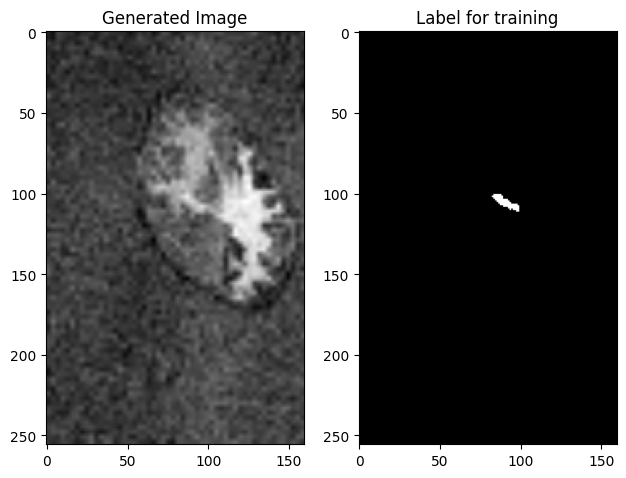

In [18]:
layer = 100
plt.figure()

plt.subplot(121)
plt.title("Generated Image")
plt.imshow(np.rot90(gen_img[..., layer].cpu()), cmap="gray")
plt.subplot(122)
plt.title("Label for training")
plt.imshow(np.rot90(input_label[..., layer].cpu()), cmap="gray")
           
plt.tight_layout()
plt.show()

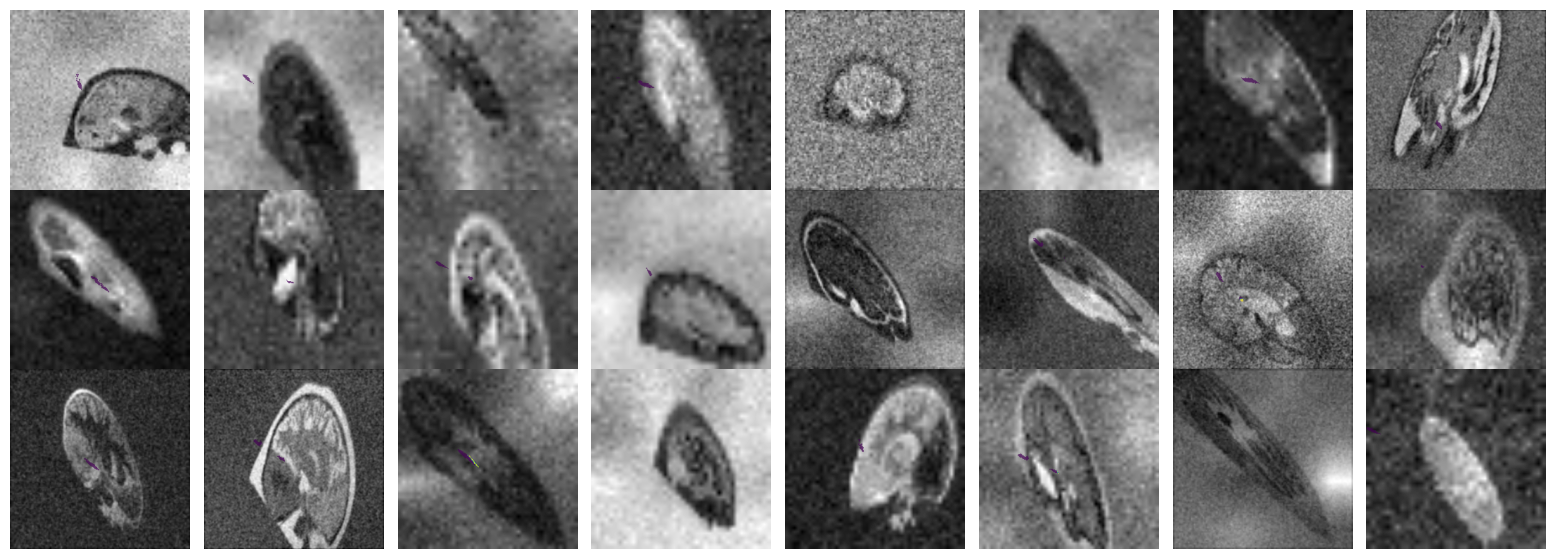

In [19]:
def show_examples(label, layer, nrows=3, ncols=8):
    fig, ax = plt.subplots(nrows, ncols, figsize=(20, 7))

    for i in range(nrows):
        for j in range(ncols):
            gen_img, gen_label = get_img(label)
            gen_img = gen_img.cpu()
            gen_label = gen_label.cpu()

            ax[i][j].imshow(np.rot90(gen_img[layer, :, :]), cmap="gray")
            ax[i][j].axis("off")
            ax[i][j].imshow(np.rot90(gen_label[layer, :, :]), alpha = 0.7 * np.rot90(gen_label[..., layer]))
            ax[i][j].axis("off")
    
    plt.subplots_adjust(wspace=0., hspace=0.)
    plt.plot()
    
    return

show_examples(label, 100)